<a href="https://colab.research.google.com/github/fridriscvski/Classificador_Cisteina/blob/main/Classificador_cisteina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
classes = os.listdir('dados')
column_names = (['nm','intensidade'])
merged = None
df_final = None

for classe in classes:
    if classe == ".DS_Store":
        continue
    files = os.listdir('dados/' + classe)
    for index, file in enumerate(files):
        path = "dados/" + classe + '/' + file
        df = pd.read_csv(path,sep="\t",
        header= None, names = column_names ,decimal=',', skiprows=17, skipfooter=1, engine='python')
        df = df.astype(float)
        merged = df if merged is None else pd.merge(merged, df, on='nm')
    merged_T = merged.T
    merged_T = pd.DataFrame(merged_T.values[1:], columns=merged_T.loc["nm"])
    merged_T["classe"] = classe                                                           #Matriz Transposta
    df_final = merged_T if df_final is None else pd.concat([df_final, merged_T])
    merged_T = None
    merged = None

print("\n FINAL \n")
df_classe = df_final["classe"]
df_final = df_final.iloc[: , :-80]                #Retirando Zonas de Incertezas
df_final = df_final.iloc[:,80:]
df_final["classe"] = df_classe


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score

X = df_final.drop('classe', axis=1)
y = df_final['classe']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Apply PCA
pca = PCA(n_components=2)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


Text(0, 0.5, 'Principal Component 2')

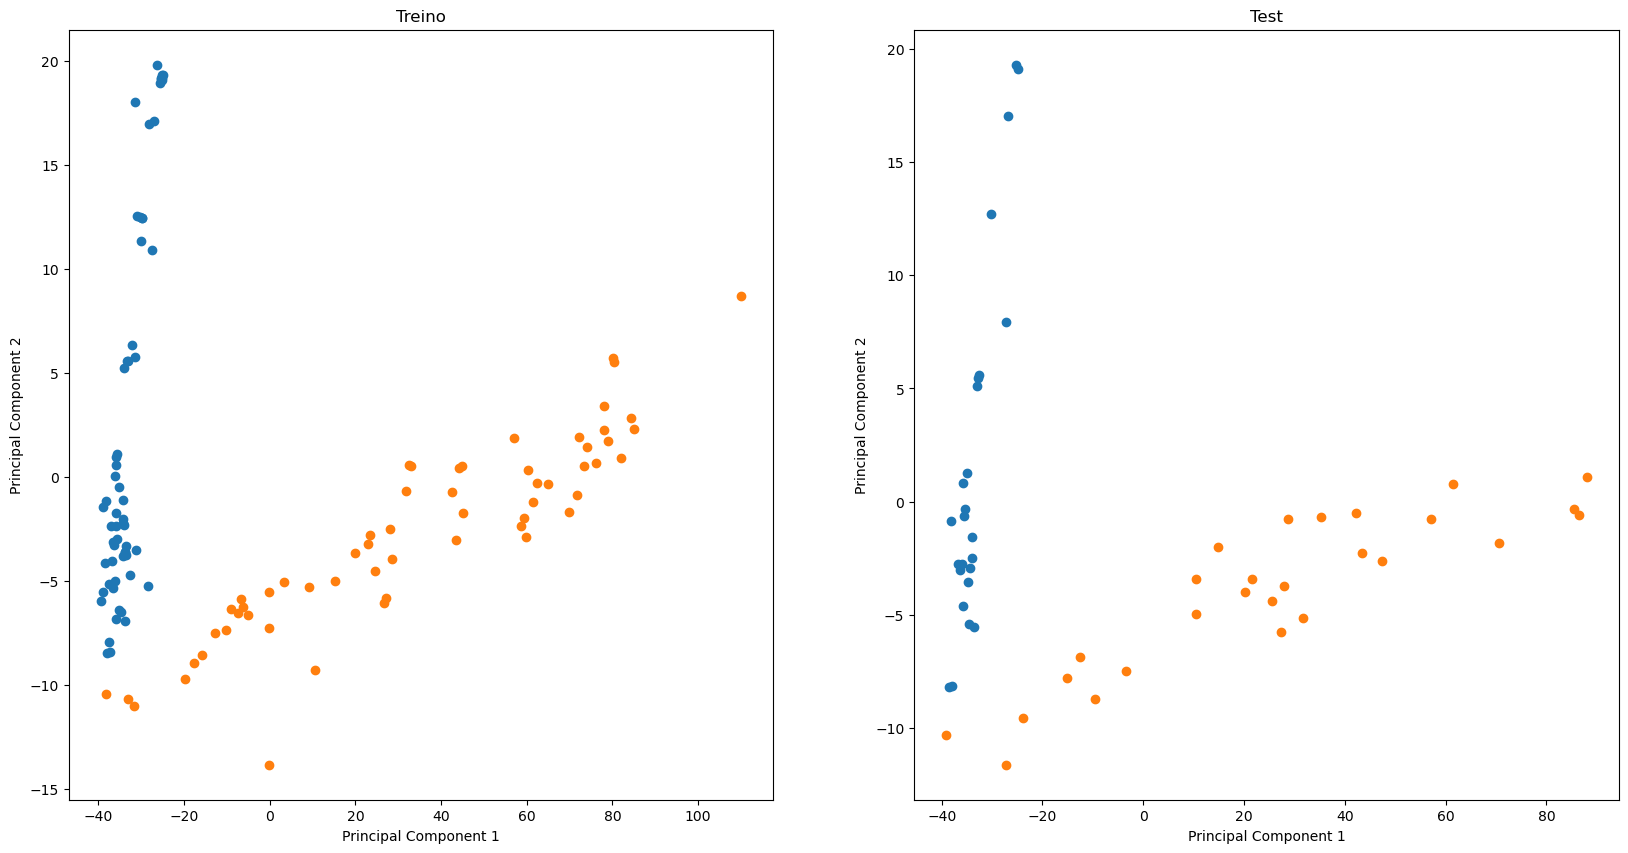

In [ ]:
data_pca_train = {
    'x1': X_train_pca[:, 0],
    'x2': X_train_pca[:, 1],
}

df_pca_train = pd.DataFrame(data_pca_train)
df_pca_train['classe'] = y_train.values

acetilcisteina_train = df_pca_train[df_pca_train['classe'] == 'Acetilcisteina']
cisteina_train = df_pca_train[df_pca_train['classe'] == 'Cisteina']

data_pca_test = {
    'x1': X_test_pca[:, 0],
    'x2': X_test_pca[:, 1],
}

df_pca_test = pd.DataFrame(data_pca_test)
df_pca_test['classe'] = y_test.values

acetilcisteina_test = df_pca_test[df_pca_test['classe'] == 'Acetilcisteina']
cisteina_test = df_pca_test[df_pca_test['classe'] == 'Cisteina']

_, axs = plt.subplots(1,2, figsize=(20, 10))
axs[0].title.set_text('Treino')
axs[0].scatter(acetilcisteina_train['x1'], acetilcisteina_train['x2'])
axs[0].scatter(cisteina_train['x1'], cisteina_train['x2'])
axs[1].title.set_text('Test')
axs[1].scatter(acetilcisteina_test['x1'], acetilcisteina_test['x2'])
axs[1].scatter(cisteina_test['x1'], cisteina_test['x2'])
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')



/Users/marcosfridriscvski/opt/anaconda3/envs/testeconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


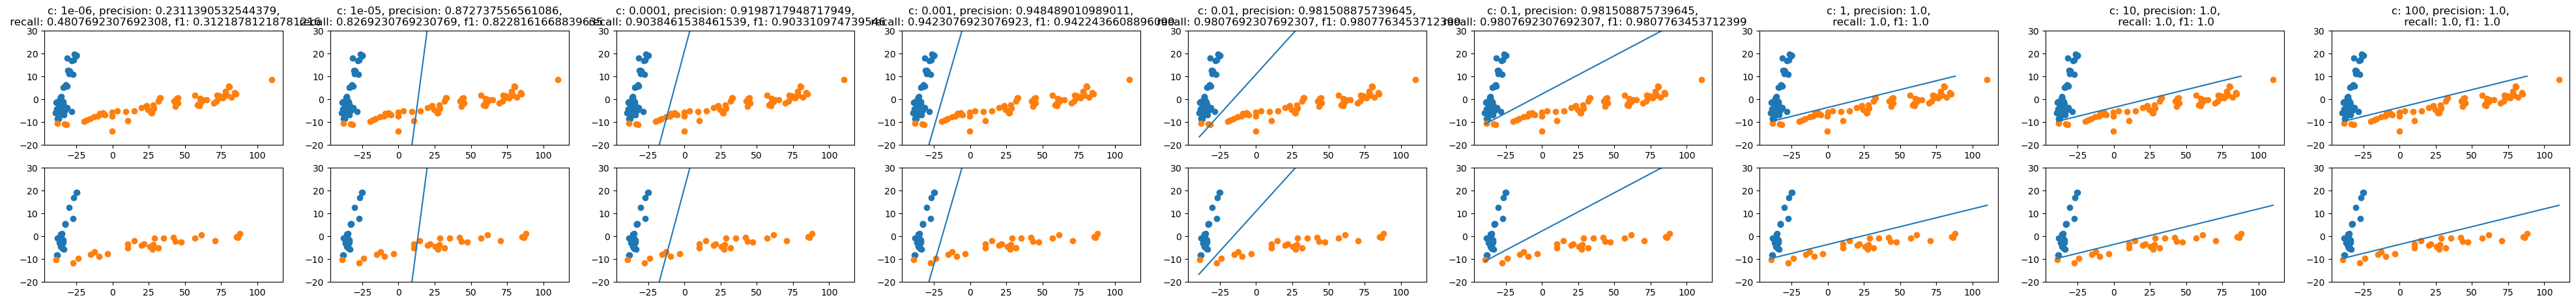

In [ ]:
cs = [1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 10, 100]
_, axs = plt.subplots(2, 9, figsize=(50, 5))

for index, c in enumerate(cs):
    model = SVC(kernel='linear', C=c)
    model.fit(X_train_pca, y_train)

    y_pred = model.predict(X_test_pca)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    ## plot train
    axs[0, index].scatter(acetilcisteina_train['x1'], acetilcisteina_train['x2'])
    axs[0, index].scatter(cisteina_train['x1'], cisteina_train['x2'])
    axs[0, index].title.set_text(f'c: {c}, precision: {precision},\n recall: {recall}, f1: {f1}')

    w = model.coef_[0]
    a =  -w[0] / w[1]
    xx = np.linspace(X_test_pca[:, 0].min(), X_test_pca[:, 0].max())
    b = model.intercept_[0] / w[1]
    yy = a * xx - b

    axs[0, index].plot(xx, yy)
    axs[0, index].set_ylim([-20, 30])

    ## plot test

    axs[1, index].scatter(acetilcisteina_test['x1'], acetilcisteina_test['x2'])
    axs[1, index].scatter(cisteina_test['x1'], cisteina_test['x2'])

    w = model.coef_[0]
    a =  -w[0] / w[1]
    xx = np.linspace(X_train_pca[:, 0].min(), X_train_pca[:, 0].max())
    b = model.intercept_[0] / w[1]
    yy = a * xx - b

    axs[1, index].plot(xx, yy)
    axs[1, index].set_ylim([-20, 30])

Text(0, 0.5, 'Principal Component 2')

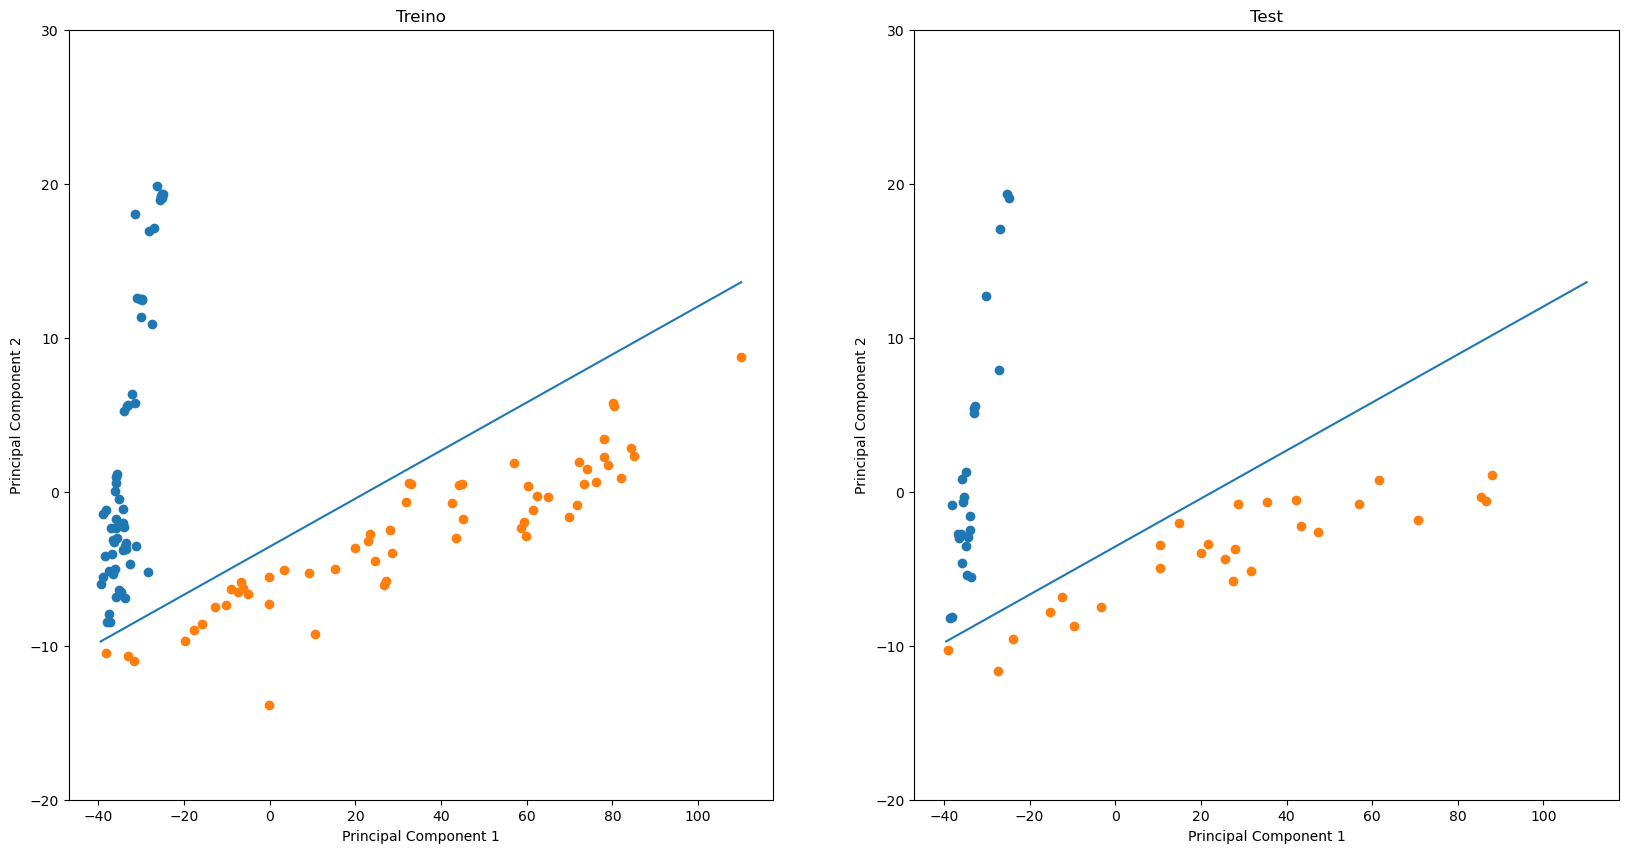

In [ ]:
_, axs = plt.subplots(1,2, figsize=(20, 10))
axs[0].title.set_text('Treino')
axs[0].scatter(acetilcisteina_train['x1'], acetilcisteina_train['x2'])
axs[0].scatter(cisteina_train['x1'], cisteina_train['x2'])
axs[1].title.set_text('Test')
axs[1].scatter(acetilcisteina_test['x1'], acetilcisteina_test['x2'])
axs[1].scatter(cisteina_test['x1'], cisteina_test['x2'])
axs[0].plot(xx, yy)
axs[1].plot(xx, yy)
axs[1].set_ylim([-20, 30])
axs[0].set_ylim([-20, 30])

axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')

In [ ]:

df_final = df_final.reset_index().drop(['index'], axis=1)
df_final.head(90)

nm,224.64,225.1,225.56,226.03,226.49,226.95,227.42,227.88,228.34,228.8,...,1004.92,1005.28,1005.64,1005.99,1006.35,1006.71,1007.07,1007.43,1007.79,classe
0,0.515,0.507,0.514,0.481,0.491,0.489,0.505,0.496,0.486,0.475,...,0.036,0.060,0.066,-0.013,0.042,0.021,-0.012,-0.005,-0.014,Cisteina
1,0.684,0.695,0.678,0.673,0.648,0.630,0.645,0.633,0.615,0.606,...,0.067,0.133,0.075,0.043,0.052,0.153,0.187,0.079,0.073,Cisteina
2,1.112,1.073,1.041,1.022,1.020,1.024,0.994,0.986,0.960,0.953,...,0.252,0.390,0.318,0.264,0.278,0.315,0.278,0.119,0.237,Cisteina
3,1.083,1.039,1.033,1.039,1.004,0.994,0.974,0.952,0.920,0.919,...,0.299,0.314,0.334,0.351,0.156,0.258,0.316,0.331,0.237,Cisteina
4,0.686,0.671,0.655,0.658,0.633,0.627,0.621,0.637,0.596,0.597,...,0.100,0.078,0.112,0.079,0.146,0.190,0.165,-0.041,0.078,Cisteina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.560,0.553,0.561,0.551,0.536,0.527,0.544,0.530,0.511,0.526,...,0.100,0.230,0.119,0.050,0.055,0.131,0.040,0.060,0.024,Cisteina
86,1.829,1.822,1.827,1.835,1.727,1.720,1.647,1.734,1.648,1.616,...,0.013,0.170,0.100,0.053,-0.000,-0.043,-0.023,-0.076,-0.031,Acetilcisteina
87,1.702,1.806,1.753,1.679,1.679,1.621,1.537,1.604,1.455,1.432,...,0.044,0.046,0.023,0.011,-0.012,0.071,0.088,-0.067,-0.023,Acetilcisteina
88,1.804,1.688,1.657,1.598,1.638,1.593,1.504,1.527,1.412,1.450,...,0.034,0.054,0.132,-0.045,0.047,0.183,0.051,-0.033,0.031,Acetilcisteina


In [ ]:

df_final.tail()


nm,224.64,225.1,225.56,226.03,226.49,226.95,227.42,227.88,228.34,228.8,...,1004.92,1005.28,1005.64,1005.99,1006.35,1006.71,1007.07,1007.43,1007.79,classe
167,1.047,1.020,0.999,0.974,0.928,0.928,0.901,0.885,0.838,0.827,...,0.020,0.052,0.023,0.025,0.012,0.030,-0.019,-0.033,-0.023,Acetilcisteina
168,2.029,2.022,2.005,1.886,1.862,1.975,1.738,2.006,1.807,1.722,...,-0.031,0.067,0.071,0.030,0.102,0.066,0.027,-0.003,-0.018,Acetilcisteina
169,2.050,1.932,1.916,1.851,1.781,1.950,1.829,1.751,1.648,1.658,...,-0.007,0.099,0.002,0.065,0.005,0.093,-0.014,-0.036,0.051,Acetilcisteina
170,1.049,1.010,1.010,0.977,0.960,0.921,0.899,0.902,0.847,0.833,...,-0.049,0.039,0.051,-0.049,-0.023,0.028,-0.028,0.045,0.036,Acetilcisteina
171,1.365,1.333,1.336,1.285,1.204,1.190,1.192,1.170,1.102,1.081,...,-0.017,0.087,0.064,0.035,0.002,0.050,-0.014,-0.118,-0.038,Acetilcisteina


In [ ]:
print(df.columns)
df_final.to_csv('df_final.csv')

Index(['nm', 'intensidade'], dtype='object')


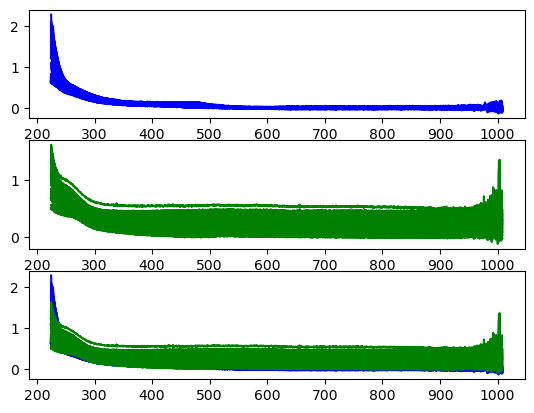

In [ ]:
grouped = df_final.groupby('classe')
dfs = {}
for name, group in grouped:
    dfs[name] = group.copy()
class_Cisteina_df = dfs['Cisteina']
class_Acetilcisteina_df = dfs['Acetilcisteina']

fig1, axs1 = plt.subplots(3)
axs1[0].plot(class_Acetilcisteina_df.drop(class_Acetilcisteina_df.columns[-1], axis=1).T, color = 'blue')
axs1[1].plot(class_Cisteina_df.drop(class_Cisteina_df.columns[-1], axis=1).T, color = 'green')                           #Plotando
axs1[2].plot(class_Acetilcisteina_df.drop(class_Acetilcisteina_df.columns[-1], axis=1).T, color = 'blue')
axs1[2].plot(class_Cisteina_df.drop(class_Cisteina_df.columns[-1], axis=1).T, color = 'green')

plt.show()

/var/folders/fv/w54sdygs3bq1p2wt5y3pxl0c0000gn/T/ipykernel_90769/3492485956.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  plota = df_final.drop("classe",1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


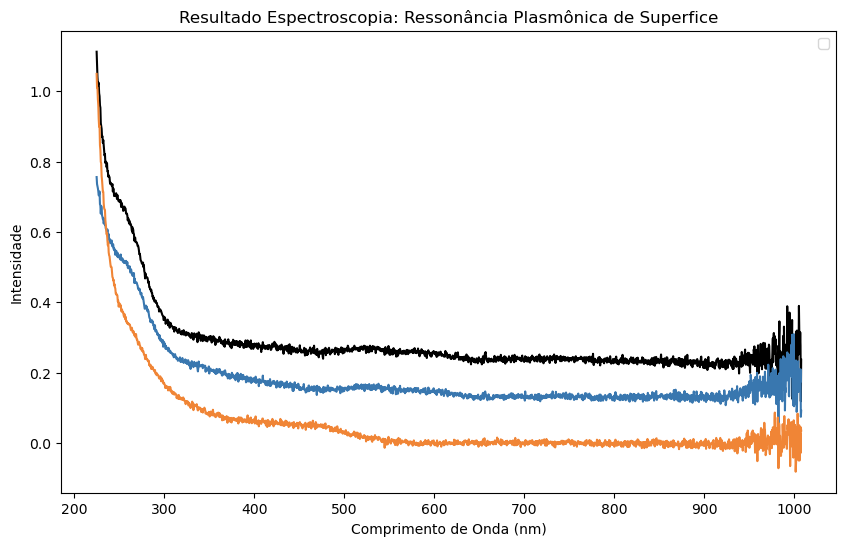

In [ ]:
plota = df_final.drop("classe",1)
plt.figure(figsize=(10,6))
plt.plot(plota.iloc[2].T,color='black')
plt.plot(plota.iloc[84].T,color='#3977AF')
plt.plot(plota.iloc[170].T,color='#F08536')
plt.title('Resultado Espectroscopia: Ressonância Plasmônica de Superfice')
plt.ylabel('Intensidade')
plt.xlabel('Comprimento de Onda (nm)')

plt.legend()
plt.show()


In [ ]:
import pandas as pd

df_teste = pd.DataFrame()
index_list = []

for k in range(0, 171):
    if k % 5 == 0:
        df_teste = df_teste.append(df_final.iloc[k])
        index_list.append(k)

df_final = df_final.drop(index_list)
df_final = df_final.reset_index(drop=True)
df_teste = df_teste.reset_index(drop=True)


/var/folders/fv/w54sdygs3bq1p2wt5y3pxl0c0000gn/T/ipykernel_90769/1922337961.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_teste = df_teste.append(df_final.iloc[k])
/var/folders/fv/w54sdygs3bq1p2wt5y3pxl0c0000gn/T/ipykernel_90769/1922337961.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_teste = df_teste.append(df_final.iloc[k])
/var/folders/fv/w54sdygs3bq1p2wt5y3pxl0c0000gn/T/ipykernel_90769/1922337961.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_teste = df_teste.append(df_final.iloc[k])
/var/folders/fv/w54sdygs3bq1p2wt5y3pxl0c0000gn/T/ipykernel_90769/1922337961.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

In [ ]:
df_teste.tail()

nm,224.64,225.1,225.56,226.03,226.49,226.95,227.42,227.88,228.34,228.8,...,1004.92,1005.28,1005.64,1005.99,1006.35,1006.71,1007.07,1007.43,1007.79,classe
30,1.313,1.232,1.220,1.175,1.147,1.128,1.093,1.085,1.019,1.022,...,-0.067,0.060,0.058,0.045,0.060,0.058,0.071,-0.028,-0.014,Acetilcisteina
31,2.036,2.082,1.863,1.864,1.812,1.900,1.706,1.840,1.739,1.683,...,0.047,0.039,0.051,-0.057,-0.040,0.063,0.010,-0.005,-0.044,Acetilcisteina
32,1.387,1.345,1.320,1.282,1.284,1.206,1.197,1.165,1.109,1.091,...,-0.007,0.067,0.058,0.043,0.039,0.002,0.020,-0.011,-0.068,Acetilcisteina
33,1.731,1.842,1.673,1.605,1.656,1.617,1.556,1.561,1.465,1.437,...,-0.031,0.092,0.049,0.021,-0.053,-0.031,-0.000,-0.011,0.012,Acetilcisteina
34,1.049,1.010,1.010,0.977,0.960,0.921,0.899,0.902,0.847,0.833,...,-0.049,0.039,0.051,-0.049,-0.023,0.028,-0.028,0.045,0.036,Acetilcisteina


In [ ]:
df_final.tail()

nm,224.64,225.1,225.56,226.03,226.49,226.95,227.42,227.88,228.34,228.8,...,1004.92,1005.28,1005.64,1005.99,1006.35,1006.71,1007.07,1007.43,1007.79,classe
132,1.635,1.547,1.520,1.478,1.447,1.500,1.387,1.428,1.290,1.263,...,-0.012,0.087,0.039,0.025,0.017,0.071,0.062,-0.023,-0.014,Acetilcisteina
133,1.047,1.020,0.999,0.974,0.928,0.928,0.901,0.885,0.838,0.827,...,0.020,0.052,0.023,0.025,0.012,0.030,-0.019,-0.033,-0.023,Acetilcisteina
134,2.029,2.022,2.005,1.886,1.862,1.975,1.738,2.006,1.807,1.722,...,-0.031,0.067,0.071,0.030,0.102,0.066,0.027,-0.003,-0.018,Acetilcisteina
135,2.050,1.932,1.916,1.851,1.781,1.950,1.829,1.751,1.648,1.658,...,-0.007,0.099,0.002,0.065,0.005,0.093,-0.014,-0.036,0.051,Acetilcisteina
136,1.365,1.333,1.336,1.285,1.204,1.190,1.192,1.170,1.102,1.081,...,-0.017,0.087,0.064,0.035,0.002,0.050,-0.014,-0.118,-0.038,Acetilcisteina


In [ ]:
len(df_final[df_final['classe'] == 'Cisteina'])

68

In [ ]:
X = df_final.drop("classe",1)               #Separando para Treinamento
y = df_final["classe"]

X.tail()

/var/folders/fv/w54sdygs3bq1p2wt5y3pxl0c0000gn/T/ipykernel_90769/2009238846.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_final.drop("classe",1)               #Separando para Treinamento


nm,224.64,225.10,225.56,226.03,226.49,226.95,227.42,227.88,228.34,228.80,...,1004.56,1004.92,1005.28,1005.64,1005.99,1006.35,1006.71,1007.07,1007.43,1007.79
132,1.635,1.547,1.520,1.478,1.447,1.500,1.387,1.428,1.290,1.263,...,0.016,-0.012,0.087,0.039,0.025,0.017,0.071,0.062,-0.023,-0.014
133,1.047,1.020,0.999,0.974,0.928,0.928,0.901,0.885,0.838,0.827,...,0.034,0.020,0.052,0.023,0.025,0.012,0.030,-0.019,-0.033,-0.023
134,2.029,2.022,2.005,1.886,1.862,1.975,1.738,2.006,1.807,1.722,...,0.078,-0.031,0.067,0.071,0.030,0.102,0.066,0.027,-0.003,-0.018
135,2.050,1.932,1.916,1.851,1.781,1.950,1.829,1.751,1.648,1.658,...,-0.014,-0.007,0.099,0.002,0.065,0.005,0.093,-0.014,-0.036,0.051
136,1.365,1.333,1.336,1.285,1.204,1.190,1.192,1.170,1.102,1.081,...,-0.056,-0.017,0.087,0.064,0.035,0.002,0.050,-0.014,-0.118,-0.038


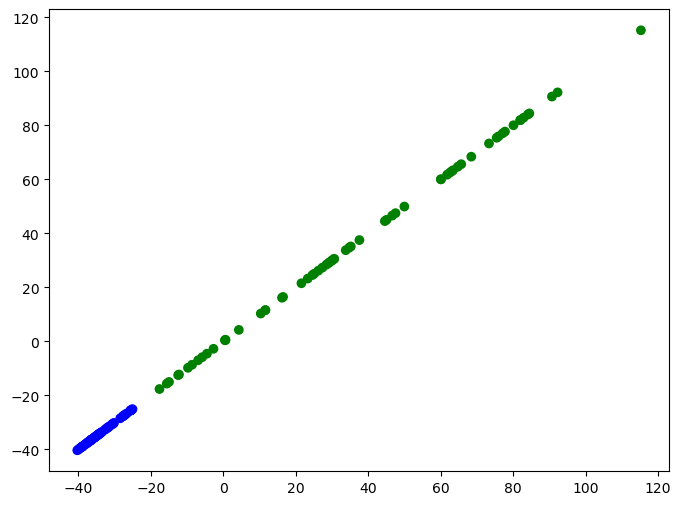

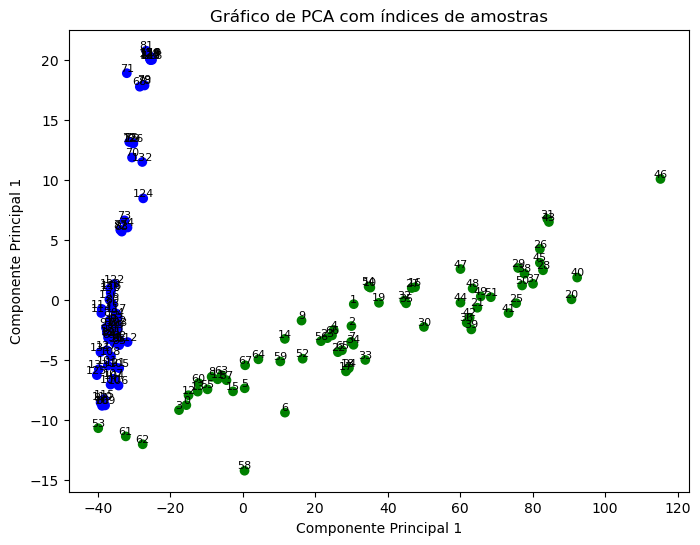

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


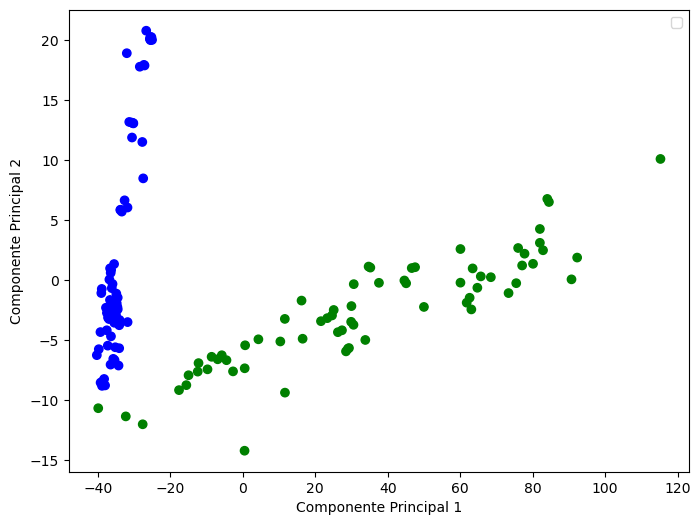

In [ ]:

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

pca_01 = PCA(n_components=1)
pca_01.fit(scaled_data)
x_pca_01 = pca_01.transform(scaled_data)

pca_02 = PCA(n_components=2)
pca_02.fit(scaled_data)
x_pca_02 = pca_02.transform(scaled_data)

pca_04 = PCA(n_components=2)
pca_04.fit(scaled_data)
x_pca_06 = pca_04.transform(scaled_data)


cor = []
for a in range (0,68):
    cor.append('green')
for z in range (68,137):
    cor.append('blue')

plt.figure(figsize=(8,6))
plt.scatter(x_pca_01[:,0],x_pca_01[:,0], c = cor)


plt.figure(figsize=(8,6))
plt.scatter(x_pca_02[:,0],x_pca_02[:,1], c = cor)
for i, (x, y) in enumerate(x_pca_02):
    plt.text(x, y, str(i), ha='center', va='bottom', fontsize=8)

plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 1")
plt.title("Gráfico de PCA com índices de amostras")
plt.show()


plt.figure(figsize=(8,6))
plt.scatter(x_pca_06[:,0],x_pca_06[:,1], c = cor)
#plt.axvline(x=-6)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()





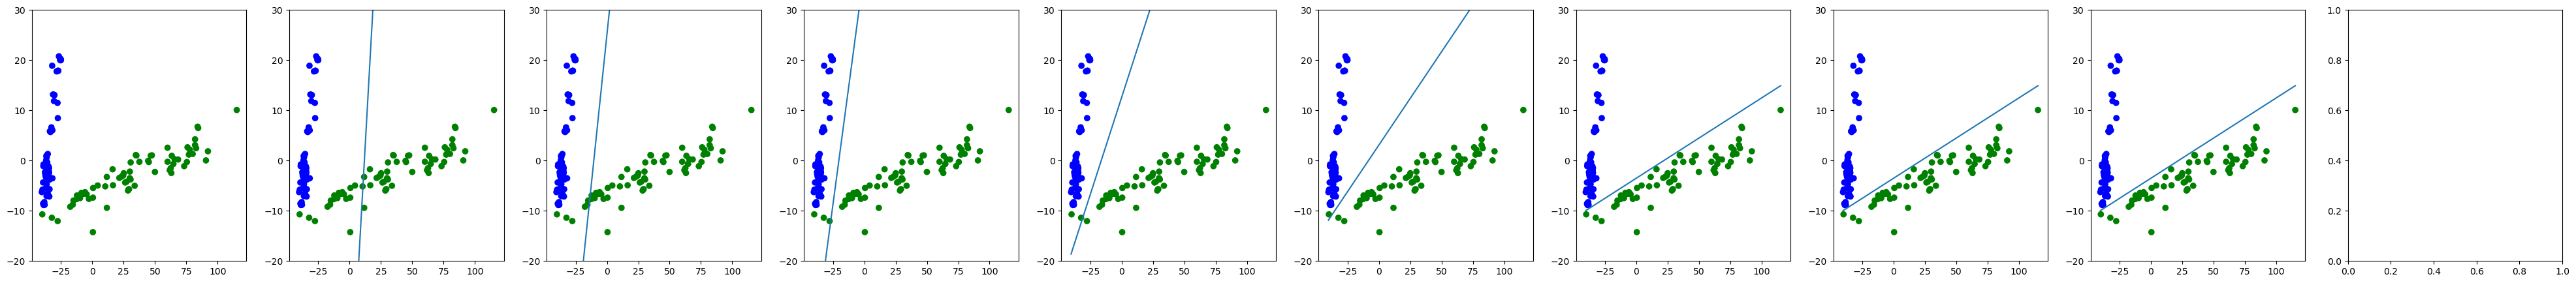

In [ ]:
cs = [1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 10, 100]
_, axs = plt.subplots(1,9, figsize=(50, 5))
for index, c in enumerate(cs):
    model = SVC(kernel='linear', C=c, random_state=1)
    model.fit(x_pca_06, y)

    w = model.coef_[0]
    a =  -w[0] / w[1]
    xx = np.linspace(x_pca_06[:, 0].min(), x_pca_06[:, 0].max())
    b = model.intercept_[0] / w[1]
    yy = a * xx - b

    axs[index].plot(xx, yy)
    axs[index].set_ylim([-20, 30])
    axs[index].scatter(x_pca_06[:,0],x_pca_06[:,1], c = cor)


    # axs[index].xlabel("Componente Principal 1")
    # axs[index].ylabel("Componente Principal 2")

In [ ]:
x_pca_05

array([[-31.47235913,  -9.90413322],
       [ -5.60698018,  -4.8436269 ],
       [ 31.94546569,   0.60619261],
       [ 11.17098406,  -3.85970856],
       [ 83.8432575 ,   4.00161313],
       [ 83.21695665,   4.52321771],
       [ 20.56104589,  -2.84017874],
       [ 45.02188459,  -0.35068332],
       [ 80.84472717,   2.57829868],
       [ 84.25002771,   1.38701507],
       [ 43.38778958,  -1.65284212],
       [ 43.28933273,  -0.88912433],
       [ 60.96123465,   2.27859761],
       [ 69.84737939,  -0.19926458],
       [-36.30505059,  -9.71916229],
       [ -8.36457915,  -7.75396892],
       [-18.33076786,  -8.80657419],
       [-22.4422914 ,  -8.68917623],
       [-31.21095831,   5.70567674],
       [-32.34746307,   5.85217018],
       [-30.88168811,   6.1865813 ],
       [-23.46230698,  19.74894818],
       [-31.93438365,  -2.85537956],
       [-37.03760554,  -0.75782555],
       [-30.88195001,  -3.93690899],
       [-32.53699395,  -3.06267474],
       [-34.31476806,  -4.2657295 ],
 

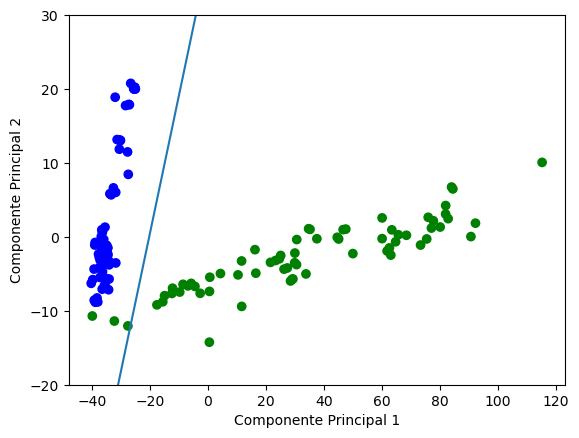

In [ ]:
w = model.coef_[0]
a =  -w[0] / w[1]
xx = np.linspace(x_pca_06[:, 0].min(), x_pca_06[:, 0].max())
b = model.intercept_[0] / w[1]
yy = a * xx - b

fig, ax = plt.subplots()
ax.set_ylim([-20, 30])
ax.scatter(x_pca_06[:,0],x_pca_06[:,1], c = cor)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
ax.plot(xx, yy)

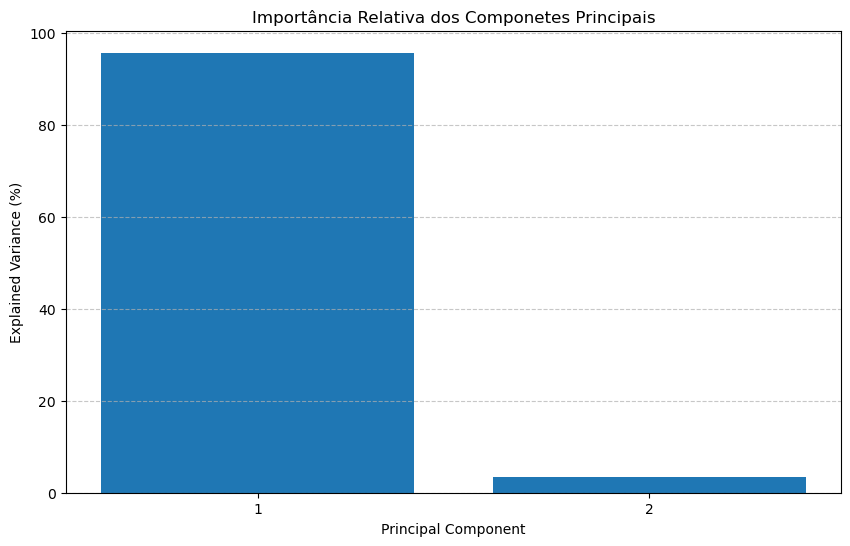

In [ ]:
explained_variances = (pca_02.explained_variance_ratio_)*100
plt.figure(figsize=(10, 6))
plt.bar(range(1, 3), explained_variances)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Importância Relativa dos Componetes Principais')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(1, 3))
plt.show()

In [ ]:
scaled_data = scaler.fit_transform(df_teste.drop("classe",1))
print(scaled_data)

[[-1.33781795 -1.34486411 -1.36112204 ... -0.82354537 -0.62289598
  -0.7029406 ]
 [-0.94804794 -0.89856108 -0.92671402 ...  0.33619183 -0.2544223
   0.02849759]
 [ 0.05867232  0.00310697  0.05373763 ...  0.63895509  0.45386599
   0.60276725]
 ...
 [ 0.60435034  0.55362289  0.59492752 ... -0.65933479 -0.64746089
  -1.02936757]
 [ 1.37052682  1.6795752   1.45160927 ... -0.7619664  -0.64746089
  -0.54577207]
 [-0.1484626  -0.20531881 -0.15739924 ... -0.90565066 -0.41818838
  -0.40069342]]


/var/folders/fv/w54sdygs3bq1p2wt5y3pxl0c0000gn/T/ipykernel_90769/2019858282.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scaled_data = scaler.fit_transform(df_teste.drop("classe",1))


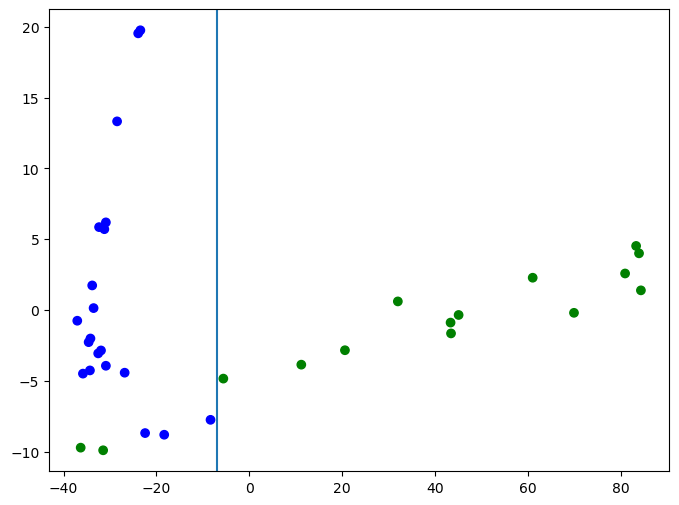

In [ ]:

x_pca_05 = pca_02.transform(scaled_data)

cor = []
for a in range (0,15):
    cor.append('green')
for z in range (16,36):
    cor.append('blue')



plt.figure(figsize=(8,6))
plt.scatter(x_pca_05[:,0],x_pca_05[:,1],c = cor)
plt.axvline(x=-7)
plt.show()

Text(0, 0.5, 'Componente Principal 2')

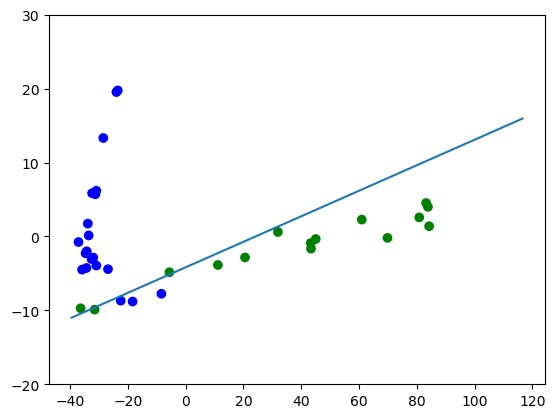

ValueError: Image size of 75229x13729 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x600 with 1 Axes>

In [ ]:
num_points = len(x_pca_05)
colorList = ['green' if i < 15 else 'blue' for i in range(num_points)]

fig, ax = plt.subplots()
ax.set_ylim([-20, 30])
plt.figure(figsize=(8, 6))
ax.plot(xx, yy)
ax.scatter(x_pca_05[:, 0], x_pca_05[:, 1], c=colorList)
for i, (x, y) in enumerate(x_pca_05):
    plt.text(x + 0.1, y + 0.2, str(i), ha='center', va='bottom', fontsize=8)

plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")






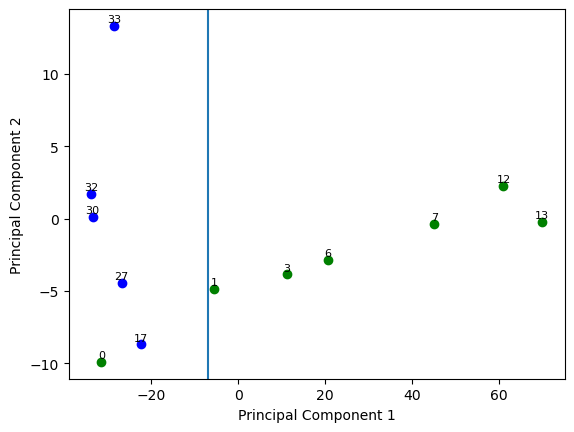

In [ ]:


# Filtering data to get only the points with specified indices
indices_to_plot = [0, 1, 3, 6, 7, 12, 13, 17, 27, 30, 32, 33]

points_to_plot = x_pca_05[np.array(indices_to_plot)]
colors_to_plot = np.array(cor)[np.array(indices_to_plot)]

for i, (x, y) in zip(indices_to_plot, points_to_plot):
    if i in [0, 1, 3, 6, 7, 12, 13]:
        plt.scatter(x, y, c='green')
    else:
        plt.scatter(x, y, c='blue')


# Adding the sample indices with adjusted position
for i, (x, y) in zip(indices_to_plot, points_to_plot):
    plt.text(x + 0.02, y + 0.1, str(i), ha='center', va='bottom', fontsize=8)


plt.axvline(x=-7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.show()

In [ ]:
inverse_transform_matrix = pca_02.components_
print(inverse_transform_matrix)

[[ 0.00577791  0.00587376  0.00570522 ...  0.02196444  0.02218896
   0.02226294]
 [ 0.11134955  0.11153501  0.11213433 ... -0.00095634 -0.00753841
  -0.00460813]]


In [ ]:

reconstructed_data = x_pca_05.dot(inverse_transform_matrix) + pca_02.mean_
print(reconstructed_data)

[[-1.28466519 -1.28951873 -1.29015003 ... -0.68180086 -0.62367746
  -0.65502776]
 [-0.5717323  -0.57316803 -0.5751259  ... -0.11852199 -0.08789982
  -0.10250782]
 [ 0.25207725  0.25525177  0.25023086 ...  0.70108439  0.70426686
   0.70840659]
 ...
 [-0.00231575 -0.00523641  0.00150415 ... -0.74461855 -0.76362913
  -0.76104934]
 [ 1.31843099  1.31817179  1.33095213 ... -0.63809243 -0.73214377
  -0.69522514]
 [-0.70717658 -0.71144312 -0.70809837 ... -0.78245108 -0.7609246
  -0.77673833]]


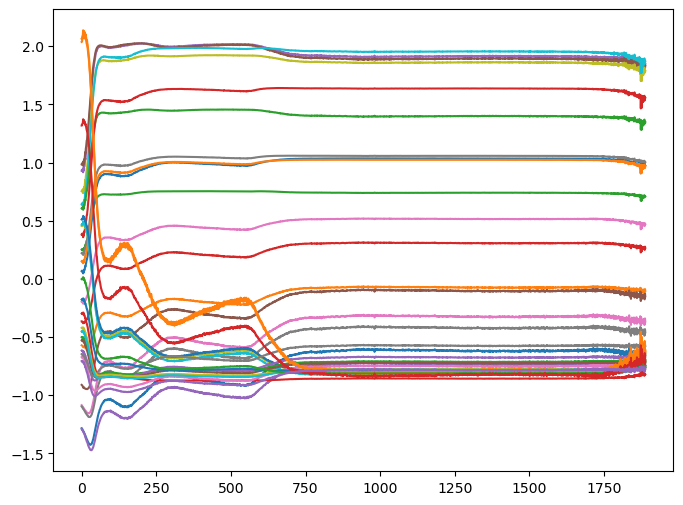

In [ ]:
teste = pd.DataFrame(reconstructed_data)
plt.figure(figsize=(8,6))
plt.plot(teste.T)
plt.show()


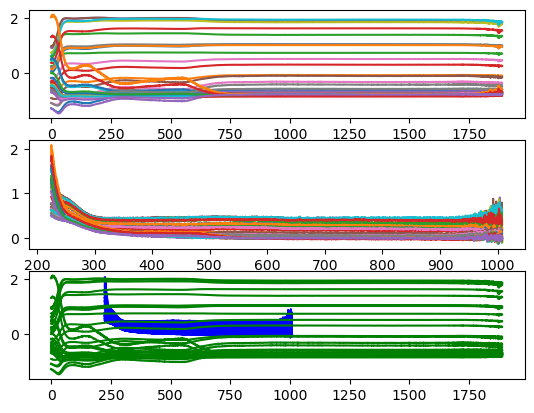

In [ ]:
fig1, axs1 = plt.subplots(3)
axs1[0].plot(teste.T)
axs1[1].plot((df_teste.drop(df_teste.columns[-1], axis=1)).T)                           #Plotando
axs1[2].plot((df_teste.drop(df_teste.columns[-1], axis=1)).T, color = 'blue')
axs1[2].plot(teste.T, color = 'green')

In [ ]:
print(pca_02.explained_variance_ratio_)

[0.95647394 0.03360904]


In [ ]:
print(pca_03.invese)

NameError: name 'pca_03' is not defined

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pca_02[:,0],x_pca_02[:,1],x_pca_02[:,2], c = cor)
plt.show()

In [ ]:

pipe = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression())         # Treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
pipe.fit(X_train, y_train)
print("Score do Treinamento com PCA: " + str(pipe.score(X_test,y_test)))

In [ ]:
len(validation_data)

In [ ]:

validation_data = pd.read_csv("/Users/marcosfridriscvski/Desktop/IC/dataset/valida.csv", on_bad_lines='skip',sep=",", header=0)
print(validation_data)

X_val = validation_data.drop("classe", 1)
y_val = validation_data["classe"]
accuracy = pipe.score(X_val, y_val)
print("Validation Accuracy: %f" % accuracy)

validation_data.plot()

In [ ]:
X_val = X_val[-10:]
y_val = y_val[-10:]

In [ ]:
accuracy = pipe.score(X_val, y_val)
print("Validation Accuracy: %f" % accuracy)

In [ ]:
X_val

In [ ]:
y_val

In [ ]:
cisteina_df_val = validation_data[validation_data['classe'] == 'cisteina']
acisteina_df_val = validation_data[validation_data['classe'] == 'Acetilcisteina']

cisteina_df_train = df_final[df_final['classe'] == 'Cisteina']
acisteina_df_train = df_final[df_final['classe'] == 'Acetilcisteina']

In [ ]:
cisteina_df_val.describe()

In [ ]:
cisteina_df_train.describe()

In [ ]:
acisteina_df_val.describe()

In [ ]:
acisteina_df_train.describe()